# Ejercicio 5 – Predicción de series temporales con LSTM

## ¿Qué es una LSTM?

Las **LSTM (Long Short-Term Memory)** son un tipo especial de redes neuronales recurrentes (RNN) diseñadas para trabajar con **secuencias de datos** como las series temporales. A diferencia de redes tradicionales, las LSTM son capaces de **"recordar" patrones a largo plazo** gracias a su arquitectura con compuertas de memoria.

Esto las hace especialmente útiles para:

- Predecir comportamientos futuros en una serie temporal
- Capturar tendencias y estacionalidades implícitas
- Modelar relaciones no lineales complejas

---

### Arquitectura básica

Una red LSTM se alimenta de "ventanas deslizantes" de datos (secuencias) y aprende a predecir el siguiente valor. Por ejemplo:

```
Input: [yₜ₋₄, yₜ₋₃, yₜ₋₂, yₜ₋₁] → Output: [yₜ]
```

La red aprende patrones en el orden temporal de los datos, lo que la hace muy potente para predicción.

---

## Flujo de trabajo

```mermaid
flowchart TD
    A[Dataset limpio] --> B[Normalización]
    B --> C[Creación de secuencias/ventanas]
    C --> D[División en train y test]
    D --> E[Construcción del modelo LSTM]
    E --> F[Entrenamiento]
    F --> G[Predicción sobre test]
    G --> H[Evaluación y visualización]
```

---

## Requisitos
```bash
pip install tensorflow scikit-learn
```

---

## Ejercicio práctico

### Paso 1: Cargar y preparar datos

In [1]:
import pandas as pd

# Cargar y preparar datos
df = pd.read_csv("data/m5_consumo_energia_train.csv", index_col=0)
df = df.set_index(pd.to_datetime(df.index))

df['dt'] = df.index

# Usamos solo la columna objetivo
serie = df["Energia Consumida"].fillna(method="ffill")

/var/folders/kh/vywr4v293s1fmshzbj358gw40000gn/T/ipykernel_5785/641227134.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = df["Energia Consumida"].fillna(method="ffill")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165 entries, 2024-07-01 to 2024-12-12
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Energia Consumida  165 non-null    float64       
 1   Temperatura        165 non-null    float64       
 2   Humedad            165 non-null    float64       
 3   dt                 165 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 6.4 KB


---

### Paso 2: Normalizar los datos

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

---

### Paso 3: Crear secuencias de entrada/salida

In [4]:
def crear_secuencias(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 30  # Usamos los últimos 30 días para predecir 1
X, y = crear_secuencias(serie_scaled, n_steps)

# Redimensionar X para LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

---

### Paso 4: Dividir en entrenamiento y validación

In [5]:
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
print("Tamaño de dataset de entrenamiento: {}".format(len(X_train)))
print("Tamaño de dataset de test: {}".format(len(X_val)))

Tamaño de dataset de entrenamiento: 108
Tamaño de dataset de test: 27


---

### Paso 5: Construir y entrenar el modelo LSTM

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

2025-04-03 17:26:04.302637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 617ms/step - loss: 0.2576 - val_loss: 0.0946
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.2111 - val_loss: 0.0706
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.1645 - val_loss: 0.0523
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.1146 - val_loss: 0.0379
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0680 - val_loss: 0.0336
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0380 - val_loss: 0.0557
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0427 - val_loss: 0.0425
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0385 - val_loss: 0.0381
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0378 - val_loss: 0.0371
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.0363 - val_loss: 0.0412
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0264 - val_loss: 0.0436
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0381 

---

### Paso 6: Predecir y evaluar

In [7]:
y_pred = model.predict(X_val)

# Invertir normalización
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


---

### Paso 7: Visualizar resultados

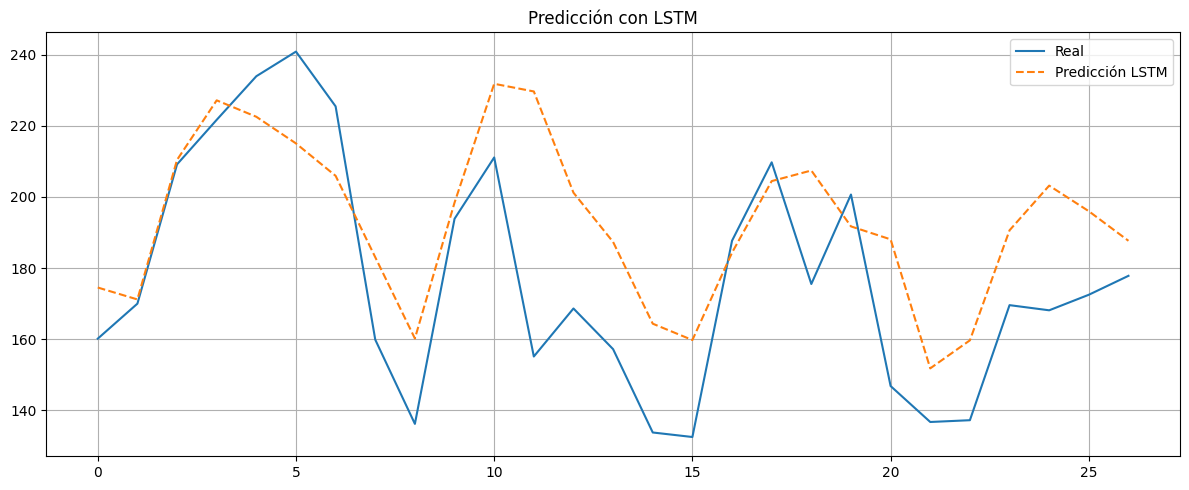

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_val_inv, label="Real")
plt.plot(y_pred_inv, label="Predicción LSTM", linestyle="--")
plt.title("Predicción con LSTM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 8: Evaluar con métricas

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 20.89
RMSE: 25.85


## Mejoras en el modelado LSTM

### Incluir características con alta correlación
El dataset contiene "Temperatura" y sabemos que afecta directamente al consumo energético. Podemos incluirla como un segundo canal de entrada en la red neuronal, lo cual permite al modelo aprender patrones complejos combinados entre tiempo y condiciones externas

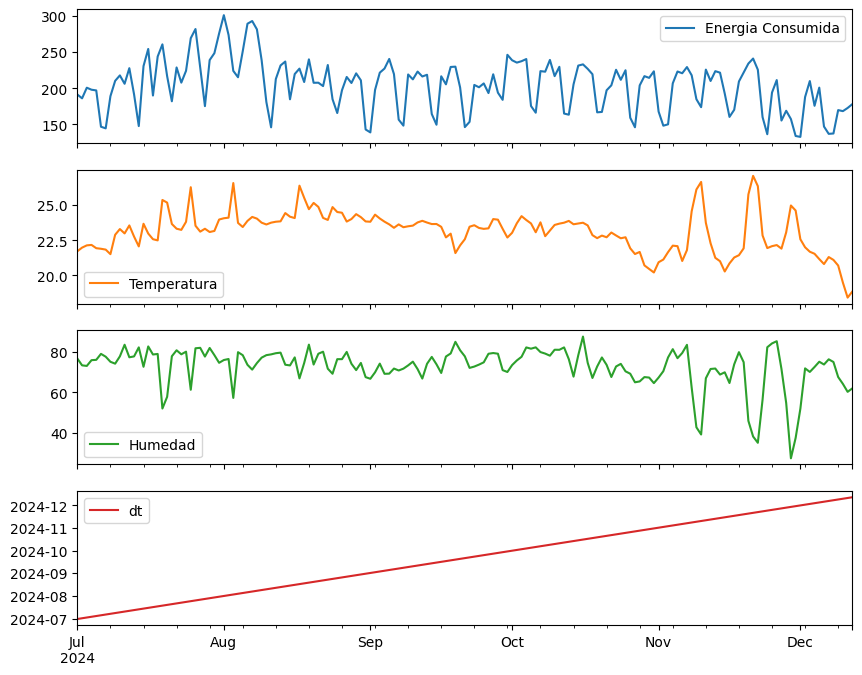

In [25]:
# Visualizar las variables clave
df.plot(subplots=True, figsize=(10, 8))
plt.show()

In [12]:
# Seleccionamos 2 características: consumo y temperatura
features = df[["Energia Consumida", "Temperatura"]].fillna(method="ffill")

# Normalizar ambas
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Crear secuencias multivariantes
def crear_secuencias_multivariable(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])  # todas las columnas
        y.append(data[i, 0])  # solo la variable objetivo (consumo)
    return np.array(X), np.array(y)

n_steps = 30
X, y = crear_secuencias_multivariable(features_scaled, n_steps)


/var/folders/kh/vywr4v293s1fmshzbj358gw40000gn/T/ipykernel_5785/235893330.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = df[["Energia Consumida", "Temperatura"]].fillna(method="ffill")


#### Dividir en entrenamiento y validación

In [13]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#### Entrenaer el modelo multivariable

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 2)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - loss: 0.1841 - val_loss: 0.0370
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0388 - val_loss: 0.0396
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0346 - val_loss: 0.0384
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0354 - val_loss: 0.0442
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0303 - val_loss: 0.0438
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0470 - val_loss: 0.0415
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0295 - val_loss: 0.0438
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0341 - val_loss: 0.0402
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0301 - val_loss: 0.0443
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0431 - val_loss: 0.0403
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0361 - val_loss: 0.0435
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/s

#### Predecir y desnormalizar

In [18]:
y_pred_scaled = model.predict(X_test)

# Desnormalizar solo la columna de consumo (índice 0)
consumo_min = scaler.data_min_[0]
consumo_max = scaler.data_max_[0]
consumo_range = consumo_max - consumo_min

y_pred = y_pred_scaled * consumo_range + consumo_min
y_true = y_test.reshape(-1, 1) * consumo_range + consumo_min


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


#### Visualizar resultados

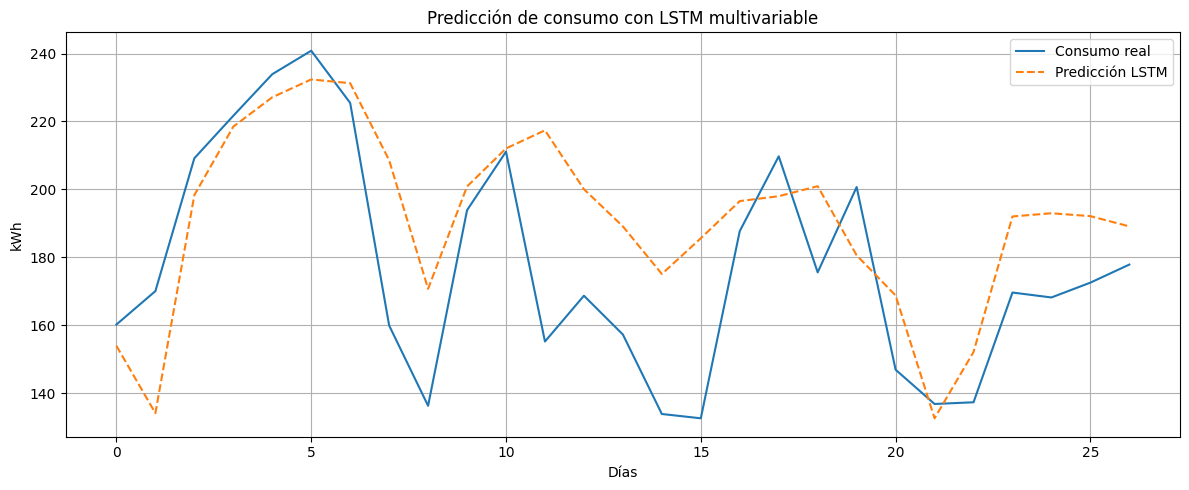

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(y_true, label="Consumo real")
plt.plot(y_pred, label="Predicción LSTM", linestyle="--")
plt.title("Predicción de consumo con LSTM multivariable")
plt.xlabel("Días")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Evaluar el modelo


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 21.23
RMSE: 26.67


**Nota:** Probar a aumentar el número de épocas o probar a modificar el tamaño de batch

### Aumentar la complejidad del modelo
El modelo original tiene una sola capa LSTM con 50 unidades. Podemos probar:

 - Capas LSTM empotradas (stacked LSTM)
 - Dropout para evitar sobreajuste
 - Función de activación tanh y relu combinadas

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - loss: 0.1115 - val_loss: 0.0438
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0407 - val_loss: 0.0461
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0459 - val_loss: 0.0476
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0473 - val_loss: 0.0424
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0429 - val_loss: 0.0462
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0375 - val_loss: 0.0453
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0515 - val_loss: 0.0454
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0348 - val_loss: 0.0468
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0448 - val_loss: 0.0509
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0487 - val_loss: 0.0444
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0377 - val_loss: 0.0452
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s

In [22]:
y_pred_scaled = model.predict(X_test)

# Desnormalizar solo la columna de consumo (índice 0)
consumo_min = scaler.data_min_[0]
consumo_max = scaler.data_max_[0]
consumo_range = consumo_max - consumo_min

y_pred = y_pred_scaled * consumo_range + consumo_min
y_true = y_test.reshape(-1, 1) * consumo_range + consumo_min


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


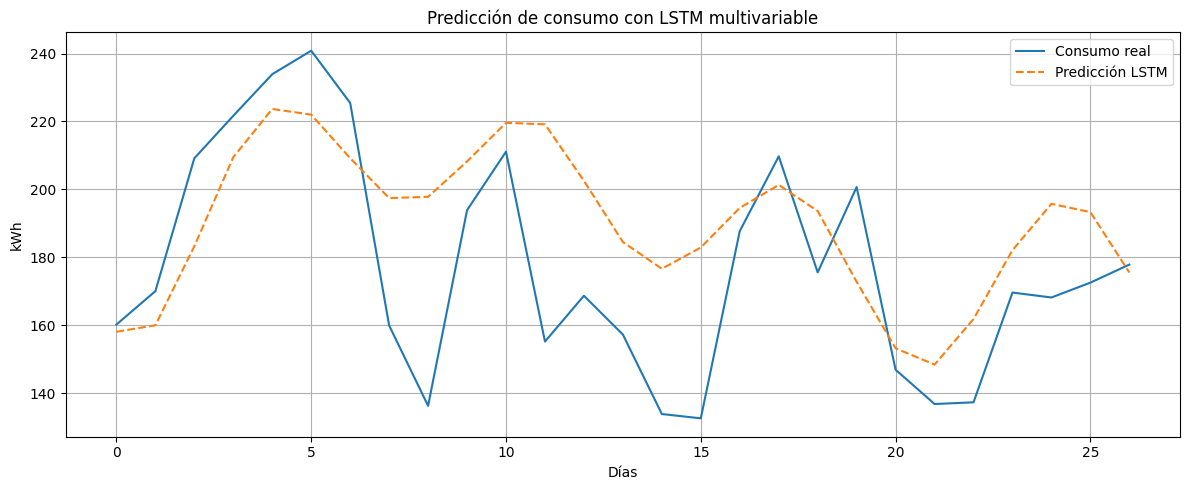

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(y_true, label="Consumo real")
plt.plot(y_pred, label="Predicción LSTM", linestyle="--")
plt.title("Predicción de consumo con LSTM multivariable")
plt.xlabel("Días")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 22.32
RMSE: 27.77


---

## ✅ Resultado esperado

- Preparar series temporales para modelos LSTM.
- Construir y entrenar una red neuronal secuencial.
- Comparar los resultados de predicción con datos reales.
- Evaluar el rendimiento con MAE y RMSE.